In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
import keras
from keras.models import Sequential, Model
from keras.layers import *
from keras.utils import Sequence
from keras.layers import Conv2D, MaxPooling2D
from qkeras import *

from keras.utils import Sequence
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

import os
import random
from datetime import datetime
import time

pi = 3.14159265359

maxval=1e9
minval=1e-9

2025-06-17 16:35:49.435268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#from dataprep import *
from OptimizedDataGeneratorNew import OptimizedDataGenerator
from loss import *
from models import *
# import mdmm

tfd = tfp.distributions

In [3]:
%load_ext autoreload
%autoreload 2

In [3]:
dataset_base_dir = "/uscms/home/bweiss/nobackup/smart-pixels/"
tfrecords_base_dir = os.path.join(dataset_base_dir, "tfrecords")

# dataset_dir_train = os.path.join(dataset_base_dir, "dataset3src_50x12p5", 'mean_filt', 'train')
# dataset_dir_val = os.path.join(dataset_base_dir, "dataset3src_50x12p5", 'mean_filt', 'test')

# tfrecords_dir_train = os.path.join(tfrecords_base_dir, "TFR_train",'3src_MeanFilt3_133eThresh')
# tfrecords_dir_val   = os.path.join(tfrecords_base_dir, "TFR_val",'3src_MeanFilt3_133eThresh')

dataset_dir_train = os.path.join(dataset_base_dir, "dataset_3sr_16x16_50x12P5_parquets", 'train')
dataset_dir_val = os.path.join(dataset_base_dir, "dataset_3sr_16x16_50x12P5_parquets", 'test')

tfrecords_dir_train = os.path.join(tfrecords_base_dir, "TFR_train",'3sr_16x16')
tfrecords_dir_val   = os.path.join(tfrecords_base_dir, "TFR_val",'3sr_16x16')

# dataset_dir_train = os.path.join(dataset_base_dir, "dataset_2s_50x12P5_parquets", 'shuffled')
# dataset_dir_val = os.path.join(dataset_base_dir, "dataset3src_50x12p5", 'test')

# tfrecords_dir_train = os.path.join(tfrecords_base_dir, "TFR_train",'dataset_2s_50x12P5_OG_shuffled')
# tfrecords_dir_val   = os.path.join(tfrecords_base_dir, "TFR_val",'dataset_2s_50x12P5_OG_shuffled')


# tfrecords_dir_train = os.path.join(tfrecords_base_dir, "TFR_train",'2TS_OG')
# tfrecords_dir_val   = os.path.join(tfrecords_base_dir, "TFR_val",'2TS_OG')

In [4]:
len(os.listdir(dataset_dir_train))

80

In [5]:
batch_size = 5000
val_batch_size = 5000
train_file_size = 80
val_file_size = 20

In [13]:
start_time = time.time()
validation_generator = OptimizedDataGenerator(
    dataset_base_dir = dataset_dir_train,
    file_type = "parquet",
    data_format = "3D",
    batch_size = val_batch_size,
    file_count = val_file_size,
    to_standardize= True,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,16,16), # (20,13,21),
    transpose = (0,2,3,1),
    shuffle = False, 
    files_from_end=True,

    tfrecords_dir = tfrecords_dir_val,
    use_time_stamps = [0, 19], #-1
    noise = -1,
    select_contained = False,
    max_workers = 2
)

print("--- Validation generator %s seconds ---" % (time.time() - start_time))

# validation_generator.debug()

Directory /uscms/home/bweiss/nobackup/smart-pixels/tfrecords/TFR_val/3sr_16x16 is removed...


Saving batches as TFRecords: 100%|██████████| 78/78 [00:14<00:00,  5.30it/s]


--- Validation generator 22.215576171875 seconds ---


In [10]:
print(len(validation_generator[0][0]))

5000


In [11]:
# training generator
start_time = time.time()
training_generator = OptimizedDataGenerator(
    dataset_base_dir = dataset_dir_train,
    file_type = "parquet",
    data_format = "3D",
    batch_size = batch_size,
    file_count = train_file_size,
    to_standardize= True,
    include_y_local= False,
    labels_list = ['x-midplane','y-midplane','cotAlpha','cotBeta'],
    input_shape = (2,16,16), # (20,13,21),
    transpose = (0,2,3,1),
    shuffle = False, # True 

    tfrecords_dir = tfrecords_dir_train,
    use_time_stamps = [0, 19], #-1
    noise = -1,
    select_contained = True,
    max_workers = 2
)
print("--- Training generator %s seconds ---" % (time.time() - start_time))

Directory /uscms/home/bweiss/nobackup/smart-pixels/tfrecords/TFR_train/3sr_16x16 does not exist and cannot be removed.


Saving batches as TFRecords: 100%|██████████| 83/83 [00:25<00:00,  3.23it/s]


--- Training generator 61.4472291469574 seconds ---


In [7]:
training_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_train,
    shuffle = False,
    seed = 13,
    quantize = False
)

validation_generator = OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_val,
    shuffle = False,
    seed = 13,
    quantize = False
)


2025-06-13 13:52:04.850536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-13 13:52:04.889892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-13 13:52:04.890356: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-13 13:52:04.891535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

tf.Tensor(
[[-0.33888975 -0.36827895  0.21131036 -0.48437527]
 [ 0.35810393 -0.07309517 -0.15779756 -2.5628595 ]
 [-0.7434732   0.8028412   0.73284084 -2.6053388 ]
 ...
 [ 0.20091476  0.46394742 -1.0701375  -1.1706002 ]
 [ 0.33557263  0.890665    0.6470125  -2.3743002 ]
 [-0.13836396  0.2733314   1.0113549  -1.2698406 ]], shape=(5000, 4), dtype=float32)
0.77552617


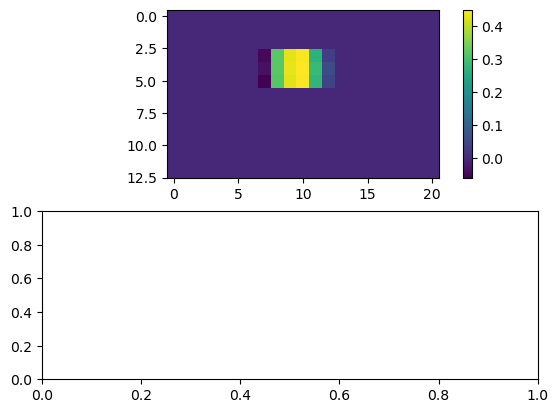

In [8]:
import matplotlib.pyplot as plt
from matplotlib import colors

n=0

cluster = validation_generator[0]
# print(np.max(cluster[0].numpy()))
print(cluster[1])
cluster=cluster[0][:,:,:,1]

print(np.max(cluster.numpy()))

fig,ax = plt.subplots(2,1)
h = ax[0].imshow(cluster[n])
fig.colorbar(h)

# print(cl

# def MeanFilter(shape, pool_size, thresh=False):

#     inputs = Input(shape=(*shape,1), name="input")
    
#     x = keras.layers.AveragePooling2D(pool_size=(pool_size, pool_size), 
#                                       strides = (1, 1), 
#                                       padding = "same",
#                                       #data_format = "channels_first"
#                                      )(inputs)
#     if thresh:
#             apply_thresh = lambda x: tf.where(x < thresh, tf.zeros_like(x), x)
#             x = Lambda(function=apply_thresh)(x)
#     outputs = x
#     model = Model(inputs=inputs, outputs=outputs)
#     return model

# shape= (13,21)
# model3_thresh = MeanFilter(shape, 3, thresh = 0.42777381797685826
#                           )

# model3_thresh.summary()
# filter3_thresh= model3_thresh.predict(cluster)
# h=ax[1].imshow(filter3_thresh[n,:,:])
# fig.colorbar(h)

# h = ax[1].imshow(cluster)
# fig.colorbar(h)

# print(training_generator.files)

In [8]:
model=CreateModel((13,21,2),n_filters=5,pool_size=3, conv_kernel_size=5 #mean_filter=3, thresh=0.6290114754408346
                 )
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
    loss=custom_loss
)

model.summary()

2025-06-13 13:57:33.243126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-13 13:57:33.281921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-13 13:57:33.282281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-13 13:57:33.283158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 21, 2)]       0         
                                                                 
 q_separable_conv2d (QSepara  (None, 9, 17, 5)         65        
 bleConv2D)                                                      
                                                                 
 q_activation (QActivation)  (None, 9, 17, 5)          0         
                                                                 
 q_conv2d (QConv2D)          (None, 9, 17, 5)          30        
                                                                 
 q_activation_1 (QActivation  (None, 9, 17, 5)         0         
 )                                                               
                                                                 
 average_pooling2d (AverageP  (None, 3, 5, 5)          0     

In [9]:
from datetime import datetime

fingerprint = '%08x' % random.randrange(16**8)
timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
os.makedirs("trained_models", exist_ok=True)
training_name = '3src_MeanFilt3_133eThresh_preDG'
base_dir = f'./trained_models/model-{fingerprint}-{training_name}-checkpoints'
os.makedirs(base_dir, exist_ok=True)  
checkpoint_filepath = base_dir + '/weights.{epoch:02d}-t{loss:.2f}-v{val_loss:.2f}.hdf5'

In [10]:
print(fingerprint)

372eef38


In [11]:
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, Callback

early_stopping_patience = 50

class CustomModelCheckpoint(ModelCheckpoint):
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        checkpoints = [f for f in os.listdir(base_dir) if f.startswith('weights')]
        # .sort() does not order weight file strings numerically
        if len(checkpoints) > 1:
            checkpoints.sort(key=lambda x: os.path.getmtime(os.path.join(base_dir,x)))
            for checkpoint in checkpoints[:-1]:
                os.remove(os.path.join(base_dir, checkpoint))

es = EarlyStopping(patience=early_stopping_patience, restore_best_weights=True)

mcp = CustomModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

csv_logger = CSVLogger(f'{base_dir}/training_log.csv', append=True)

In [12]:
history = model.fit(
        x=training_generator,
        validation_data=validation_generator,
        callbacks=[es, mcp, csv_logger],
        epochs=500,
        shuffle=False,
        verbose=1
    )

Epoch 1/500
 1/93 [..............................] - ETA: 3:30 - loss: 103435.2734

2025-06-13 13:58:24.327124: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-06-13 13:58:24.348761: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8800
2025-06-13 13:58:24.374632: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x558c795f21a0


93/93 [==============================] - ETA: 0s - loss: 35659.9805
Epoch 1: val_loss improved from inf to 16441.68164, saving model to ./trained_models/model-372eef38-3src_MeanFilt3_133eThresh_preDG-checkpoints/weights.01-t35659.98-v16441.68.hdf5
93/93 [==============================] - 10s 88ms/step - loss: 35659.9805 - val_loss: 16441.6816
Epoch 2/500
93/93 [==============================] - ETA: 0s - loss: 15510.9150
Epoch 2: val_loss improved from 16441.68164 to 13977.23926, saving model to ./trained_models/model-372eef38-3src_MeanFilt3_133eThresh_preDG-checkpoints/weights.02-t15510.92-v13977.24.hdf5
93/93 [==============================] - 7s 79ms/step - loss: 15510.9150 - val_loss: 13977.2393
Epoch 3/500
93/93 [==============================] - ETA: 0s - loss: 13141.5811
Epoch 3: val_loss improved from 13977.23926 to 11718.59375, saving model to ./trained_models/model-372eef38-3src_MeanFilt3_133eThresh_preDG-checkpoints/weights.03-t13141.58-v11718.59.hdf5
93/93 [================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

